In [2]:
import random
import ast
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import axelrod as axl

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
from joblib import Parallel, delayed
import xgboost as xgb


In [4]:
df_smpi = pd.read_csv('../simulated_data/precalculated_metrics/smpi_data_for_SHAP.csv')

In [5]:
df_smpi.head()


,Unnamed: 0,row,col,avg_score_row,avg_score_col,score_diff_row_minus_col,row_wins_binary,coop_rate_row,coop_rate_col,mean_coop_rate_pair,RPI,CPI
0,0,Raider,Raider,1.66,1.660,0.000,0,0.330,0.330,0.3300,0.000000,0.099000
1,1,Raider,Cooperator,5.00,0.000,5.000,1,0.000,1.000,0.5000,1.000000,0.850000
2,2,Raider,GrudgerAlternator,2.99,0.515,2.475,1,0.005,0.500,0.2525,0.706134,0.570044
3,3,Raider,Evolved ANN 5 Noise 05,2.86,2.860,0.000,0,0.865,0.865,0.8650,0.000000,0.259500
4,4,Raider,Forgiver,1.01,1.035,-0.025,0,0.010,0.005,0.0075,-0.012225,-0.006307


In [6]:
strategies = [axl.Raider(),axl.Cooperator(), axl.GrudgerAlternator(), axl.EvolvedANNNoise05(), axl.Forgiver()]


In [7]:
strategy_order = [player.__class__.__name__ for player in strategies]

strategy_mapping = {name: player.__class__ for name, player in zip(strategy_order, strategies)}

strategy_mapping

{'Raider': axelrod.strategies.finite_state_machines.Raider,
 'Cooperator': axelrod.strategies.cooperator.Cooperator,
 'GrudgerAlternator': axelrod.strategies.grudger.GrudgerAlternator,
 'EvolvedANNNoise05': axelrod.strategies.ann.EvolvedANNNoise05,
 'Forgiver': axelrod.strategies.forgiver.Forgiver}

In [8]:
strategy_order

['Raider', 'Cooperator', 'GrudgerAlternator', 'EvolvedANNNoise05', 'Forgiver']

In [9]:
MAX_COUNT = 5          # each strategy appears between 0 and 5 times
NUM_TOTAL_COMPS = (MAX_COUNT+1) ** len(strategy_order)  # 6^5 = 7776
NUM_SIMULATIONS = 5000   # number of tournaments to simulate (sampled from all compositions)
TOURNS = 200           # turns per tournament
REPETITIONS = 10      # repetitions per tournament


def get_tournament_winners_by_score(results, players, use_normalised=True):
    if use_normalised:
        if hasattr(results.normalised_scores, "compute"):
            scores_matrix = np.array(results.normalised_scores.compute())
        else:
            scores_matrix = np.array(results.normalised_scores)
    else:
        if hasattr(results.scores, "compute"):
            scores_matrix = np.array(results.scores.compute())
        else:
            scores_matrix = np.array(results.scores)
    average_scores = [np.mean(scores) for scores in scores_matrix]
    score_dict = {player.__class__.__name__: avg for player, avg in zip(players, average_scores)}
    print("Average scores:", score_dict)
    max_score = max(average_scores)
    winners = [
        player.__class__.__name__ for player, avg in zip(players, average_scores)
        if abs(avg - max_score) < 0.001
    ]
    # Remove duplicates.
    unique_winners = []
    for w in winners:
        if w not in unique_winners:
            unique_winners.append(w)
    print("Winners for this tournament:", unique_winners, "\n")
    return unique_winners

def run_single_tournament(composition, turns=TOURNS, repetitions=REPETITIONS):
    players = []
    for count, strat_name in zip(composition, strategy_order):
        for _ in range(count):
            players.append(strategy_mapping[strat_name]())
    print("Tournament composition:", composition)
    tourn = axl.Tournament(players, turns=turns, repetitions=repetitions)
    results_tourn = tourn.play()
    coop_matrix = results_tourn.cooperation
    total_cooperations = sum(sum(row) for row in coop_matrix)
    total_moves = len(coop_matrix) ** 2 * repetitions
    coop_rate = total_cooperations / total_moves if total_moves > 0 else 0.0
    winners = get_tournament_winners_by_score(results_tourn, players)
    return {
        "composition": composition,
        "coop_rate": coop_rate,
        "winning_strategy": winners
    }


In [10]:
all_comps = [tuple(x) for x in itertools.product(range(MAX_COUNT + 1), repeat=len(strategy_order))]
print("Total possible compositions:", len(all_comps))  # Should be 7776

# selected_comps = random.sample(all_comps, NUM_SIMULATIONS)
# print("Selected compositions for simulation:", len(selected_comps))




Total possible compositions: 7776


In [11]:
import ast, numpy as np, pandas as pd

# --- strategy lists you already know -----------------------------------------
n_strat        = len(strategy_order)                    # 5
# upper-tri including diagonal ⇒ 5·(5+1)/2 = 15 EffCPI columns
eff_cols = [f"EffCPI_{i}{j}"
            for i in range(n_strat)
            for j in range(i, n_strat)]

# ──────────────────────────────────────────────────────────────────────────────
# 1.  CPI lookup  (row × col  →  CPI value)   25 entries, symmetric
# ──────────────────────────────────────────────────────────────────────────────
cpi_lookup = {}

for _, r in df_smpi.iterrows():
    i, j, val = r["row"], r["col"], float(r["CPI"])
    cpi_lookup[(i, j)] = val
    cpi_lookup[(j, i)] = val          # symmetry
# make sure every self-pair exists
for s in strategy_order:
    cpi_lookup.setdefault((s, s), 0.0)


In [12]:
cpi_lookup

{('Raider', 'Raider'): 0.099,
 ('Raider', 'Cooperator'): -0.5499999998599999,
 ('Cooperator', 'Raider'): -0.5499999998599999,
 ('Raider', 'GrudgerAlternator'): -0.4185438657648234,
 ('GrudgerAlternator', 'Raider'): -0.4185438657648234,
 ('Raider', 'Evolved ANN 5 Noise 05'): 0.2595,
 ('Evolved ANN 5 Noise 05', 'Raider'): 0.2595,
 ('Raider', 'Forgiver'): 0.0108074572085293,
 ('Forgiver', 'Raider'): 0.0108074572085293,
 ('Cooperator', 'Cooperator'): 0.3,
 ('Cooperator', 'GrudgerAlternator'): 0.3,
 ('GrudgerAlternator', 'Cooperator'): 0.3,
 ('Cooperator', 'Evolved ANN 5 Noise 05'): 0.4978216203652513,
 ('Evolved ANN 5 Noise 05', 'Cooperator'): 0.4978216203652513,
 ('Cooperator', 'Forgiver'): 0.3,
 ('Forgiver', 'Cooperator'): 0.3,
 ('GrudgerAlternator', 'GrudgerAlternator'): 0.3,
 ('GrudgerAlternator', 'Evolved ANN 5 Noise 05'): 0.2242375271017923,
 ('Evolved ANN 5 Noise 05', 'GrudgerAlternator'): 0.2242375271017923,
 ('GrudgerAlternator', 'Forgiver'): 0.3,
 ('Forgiver', 'GrudgerAlternator'

In [13]:
df_experiments = pd.read_csv('../simulated_data/simulated_tournamets/5_setup_data.csv')

In [14]:
print(df_experiments.head())

   Unnamed: 0      composition   coop_rate  \
0           0  [0, 2, 1, 2, 5]  162.660000   
1           1  [1, 1, 3, 3, 0]  145.656250   
2           2  [5, 5, 1, 5, 5]  127.369615   
3           3  [0, 1, 3, 0, 4]  200.000000   
4           4  [2, 1, 1, 0, 2]  113.277778   

                                  winning_strategy  
0                            ['GrudgerAlternator']  
1                                       ['Raider']  
2                            ['EvolvedANNNoise05']  
3  ['Cooperator', 'GrudgerAlternator', 'Forgiver']  
4                                       ['Raider']  


In [15]:
df_experiments['winning_strategy'] = df_experiments['winning_strategy'].apply(ast.literal_eval)
df_experiments['composition'] = df_experiments['composition'].apply(ast.literal_eval)



In [16]:
def strip_non_alphanum(s):
    import re, pandas as pd
    return pd.NA if pd.isna(s) else re.sub(r"[^A-Za-z0-9]", "", s)

alias = {
    "EvolvedANN5Noise05": "EvolvedANNNoise05",   
    "EvolvedANNNoise05": "EvolvedANNNoise05",   
}

def canon(name):
    """return canonical key used everywhere."""
    key = strip_non_alphanum(name)
    return alias.get(key, key)

strategy_order = [canon(s) for s in strategy_order]
S = len(strategy_order)

cpi_lookup = {}

for _, r in df_smpi.iterrows():
    i, j = canon(r["row"]), canon(r["col"])
    val  = float(r["CPI"])
    cpi_lookup[(i, j)] = val
    cpi_lookup[(j, i)] = val

from itertools import product
for a, b in product(strategy_order, repeat=2):
    cpi_lookup.setdefault((a, b), 0.0)

def build_raw_cpi_row(counts):
    eff = []
    for i, s_i in enumerate(strategy_order):
        for j, s_j in enumerate(strategy_order[i:]):
            if counts[i] > 0 and counts[j] > 0:
                eff.append(cpi_lookup[(s_i, s_j)])
            else:
                eff.append(0.0)
    return np.asarray(eff, dtype=float)

counts_mat = np.vstack(
    df_experiments["composition"]
      .apply(lambda x: np.asarray(ast.literal_eval(x), dtype=int)
                       if isinstance(x, str) else np.asarray(x, int))
)                               

cpi_mat = np.vstack(
    df_experiments["composition"]
      .apply(lambda x: build_raw_cpi_row(
          np.asarray(ast.literal_eval(x), int) if isinstance(x, str) else np.asarray(x, int)))
)                              

count_cols = [f"count_{s}" for s in strategy_order]
cpi_cols   = [f"CPI_{i}{j}" for i in range(S) for j in range(i, S)]

df_features = pd.concat(
    [df_experiments.reset_index(drop=True),
     pd.DataFrame(counts_mat, columns=count_cols),
     pd.DataFrame(cpi_mat,    columns=cpi_cols)],
    axis=1
)

print(df_features.head())


   Unnamed: 0      composition   coop_rate  \
0           0  [0, 2, 1, 2, 5]  162.660000   
1           1  [1, 1, 3, 3, 0]  145.656250   
2           2  [5, 5, 1, 5, 5]  127.369615   
3           3  [0, 1, 3, 0, 4]  200.000000   
4           4  [2, 1, 1, 0, 2]  113.277778   

                            winning_strategy  count_Raider  count_Cooperator  \
0                        [GrudgerAlternator]             0                 2   
1                                   [Raider]             1                 1   
2                        [EvolvedANNNoise05]             5                 5   
3  [Cooperator, GrudgerAlternator, Forgiver]             0                 1   
4                                   [Raider]             2                 1   

   count_GrudgerAlternator  count_EvolvedANNNoise05  count_Forgiver  CPI_00  \
0                        1                        2               5   0.000   
1                        3                        3               0   0.099   
2    

In [17]:
df_features

,Unnamed: 0,composition,coop_rate,winning_strategy,count_Raider,count_Cooperator,count_GrudgerAlternator,count_EvolvedANNNoise05,count_Forgiver,CPI_00,...,CPI_11,CPI_12,CPI_13,CPI_14,CPI_22,CPI_23,CPI_24,CPI_33,CPI_34,CPI_44
0,0,"[0, 2, 1, 2, 5]",162.660000,[GrudgerAlternator],0,2,1,2,5,0.000,...,0.0,0.3,0.497822,0.3,0.0,0.224238,0.3,0.000,0.139764,0.0
1,1,"[1, 1, 3, 3, 0]",145.656250,[Raider],1,1,3,3,0,0.099,...,0.3,0.3,0.497822,0.3,0.3,0.224238,0.3,0.267,0.139764,0.0
2,2,"[5, 5, 1, 5, 5]",127.369615,[EvolvedANNNoise05],5,5,1,5,5,0.099,...,0.3,0.3,0.497822,0.3,0.3,0.224238,0.3,0.267,0.139764,0.3
3,3,"[0, 1, 3, 0, 4]",200.000000,"[Cooperator, GrudgerAlternator, Forgiver]",0,1,3,0,4,0.000,...,0.0,0.3,0.497822,0.0,0.0,0.224238,0.3,0.000,0.000000,0.0
4,4,"[2, 1, 1, 0, 2]",113.277778,[Raider],2,1,1,0,2,0.099,...,0.3,0.3,0.497822,0.0,0.3,0.224238,0.3,0.000,0.000000,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,"[1, 3, 3, 0, 4]",173.396694,[Forgiver],1,3,3,0,4,0.099,...,0.3,0.3,0.497822,0.0,0.3,0.224238,0.3,0.000,0.000000,0.3
4996,4996,"[5, 4, 2, 2, 3]",121.542969,[EvolvedANNNoise05],5,4,2,2,3,0.099,...,0.3,0.3,0.497822,0.3,0.3,0.224238,0.3,0.267,0.139764,0.3
4997,4997,"[3, 4, 2, 1, 0]",137.200000,[Raider],3,4,2,1,0,0.099,...,0.3,0.3,0.497822,0.3,0.3,0.224238,0.3,0.267,0.139764,0.0
4998,4998,"[4, 5, 3, 5, 4]",135.557823,[Raider],4,5,3,5,4,0.099,...,0.3,0.3,0.497822,0.3,0.3,0.224238,0.3,0.267,0.139764,0.3


In [18]:
TRI_LEN = S * (S + 1) // 2                       # 15 CPI cells

def to_counts(x):
    """'[2,1,3,0,4]' → np.array([2,1,3,0,4])"""
    if isinstance(x, str):
        x = ast.literal_eval(x)
    return np.asarray(x, dtype=int).ravel()

def raw_cpi_row(counts):
    """upper-triangular CPI values (0 if either strategy absent)"""
    feats = []
    for i, s_i in enumerate(strategy_order):
        for j, s_j in enumerate(strategy_order[i:]):
            v = cpi_lookup.get((s_i, s_j), 0.0)
            feats.append(v if counts[i] and counts[j] else 0.0)
    return np.asarray(feats, float)            

tournament_features = []                      
for comp in df_experiments["composition"]:
    c  = to_counts(comp)                     
    fv = np.hstack([c, raw_cpi_row(c)])      
    tournament_features.append(fv)        


X = np.vstack(tournament_features)           
coop_rate = df_experiments["coop_rate"].values.reshape(-1, 1)
X = np.hstack([X, coop_rate])                 

print("Final feature shape:", X.shape)  
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(df_experiments["winning_strategy"])

print("Multi-label target:", y_multi.shape)
print("Classes:", mlb.classes_)


Final feature shape: (5000, 21)
Multi-label target: (5000, 5)
Classes: ['Cooperator' 'EvolvedANNNoise05' 'Forgiver' 'GrudgerAlternator' 'Raider']


In [19]:
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(df_experiments['winning_strategy'])
print("Multi-label target shape:", y_multi.shape)
print("Classes (winning strategies):", mlb.classes_)

Multi-label target shape: (5000, 5)
Classes (winning strategies): ['Cooperator' 'EvolvedANNNoise05' 'Forgiver' 'GrudgerAlternator' 'Raider']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from tensorflow.keras.regularizers import l2
nn_model = Sequential([
    Dense(32, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2970 - loss: 0.6715 - val_accuracy: 0.5888 - val_loss: 0.4756
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.4913 - loss: 0.4936 - val_accuracy: 0.6837 - val_loss: 0.3517
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.6247 - loss: 0.3921 - val_accuracy: 0.7825 - val_loss: 0.2795
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6918 - loss: 0.3387 - val_accuracy: 0.8100 - val_loss: 0.2293
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.7592 - loss: 0.2842 - val_accuracy: 0.8475 - val_loss: 0.1988
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7713 - loss: 0.2606 - val_accuracy: 0.8637 - val_loss: 0.1801
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7982 - loss: 0.2411 - val_accuracy: 0.8737 - val_loss: 0.1688
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.8172 - loss: 0.2186 - val_accuracy:

In [22]:
import shap



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
unseen_comps = [c for c in all_comps
                if list(c) not in df_experiments["composition"].tolist()]

In [24]:
new_comp = random.choice(unseen_comps)

In [25]:
def build_feature_vector(comp, coop):
    """→ (1 , 21) ready for the scaler / model"""
    counts  = to_counts(comp)
    vec     = np.hstack([counts, raw_cpi_row(counts), [coop]])
    return vec.reshape(1, -1)

In [26]:
print(run_single_tournament(new_comp, turns=TOURNS, repetitions=REPETITIONS))

Tournament composition: (5, 0, 2, 3, 5)


Analysing: 100%|██████████| 25/25 [00:00<00:00, 352.29it/s]

Average scores: {'Raider': 1.875, 'GrudgerAlternator': 1.9207142857142858, 'EvolvedANNNoise05': 2.2907142857142864, 'Forgiver': 2.0228571428571422}
Winners for this tournament: ['EvolvedANNNoise05'] 

{'composition': (5, 0, 2, 3, 5), 'coop_rate': 98.71111111111111, 'winning_strategy': ['EvolvedANNNoise05']}


In [27]:
avg_coop_rate = float(df_experiments['coop_rate'].mean())

In [28]:
def nn_winner(comp_vec):
    fv = scaler.transform(build_feature_vector(comp_vec, avg_coop_rate))
    lab = (nn_model.predict(fv, verbose=0) > .5).astype(int)
    return mlb.inverse_transform(lab)[0]

print(nn_winner(new_comp))

('EvolvedANNNoise05',)


In [29]:
print("Selected unseen composition:", new_comp)

bg_idx = np.random.choice(X_train.shape[0], size=min(200, X_train.shape[0]),
                          replace=False)
background_scaled = X_train[bg_idx]       

explainer = shap.KernelExplainer(nn_model.predict, background_scaled)

avg_coop_rate = df_experiments['coop_rate'].mean()

x_new = build_feature_vector(new_comp, avg_coop_rate) 
x_new_sc = scaler.transform(x_new)


shap_vals = explainer.shap_values(x_new_sc)
shap_vals = shap_vals[0] if isinstance(shap_vals, list) else shap_vals
shap_vals = shap_vals.reshape(-1)   

feat_names = [f"count_{s}" for s in strategy_order]
feat_names += [f"SMPI_{strategy_order[i]}_vs_{strategy_order[j]}"
               for i in range(S) for j in range(i, S)]
feat_names += ["coop_rate"]                # len = 21

count_idx      = list(range(S))                 
interpret_idx  = list(range(len(feat_names)))  

imp_vals  = shap_vals[interpret_idx]
imp_names = [feat_names[i] for i in interpret_idx]


top_k = 10

if len(shap_vals) != len(feat_names):
    shap_vals = np.array(shap_vals)
    n_feats = len(feat_names)
    n_labels = shap_vals.shape[0] // n_feats
    shap_vals = shap_vals.reshape(n_labels, n_feats)
    shap_vals = shap_vals.mean(axis=0) 

imp = np.abs(shap_vals)
top_k = 10
top_idx = np.abs(imp_vals).argsort()[::-1][:top_k]

print("\nTop SHAP impacts:")
for rank, idx in enumerate(top_idx, 1):
    sign = "↑" if shap_vals[idx] > 0 else "↓"
    print(f"{rank:2d}. {feat_names[idx]:<40} {shap_vals[idx]: .4f}  ({sign})")

Selected unseen composition: (5, 0, 2, 3, 5)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


Top SHAP impacts:
 1. count_Cooperator                          0.1077  (↑)
 2. SMPI_Raider_vs_Forgiver                  -0.0436  (↓)
 3. count_EvolvedANNNoise05                  -0.0780  (↓)
 4. SMPI_Raider_vs_Cooperator                 0.0385  (↑)
 5. count_GrudgerAlternator                  -0.0123  (↓)
 6. count_Forgiver                           -0.0171  (↓)
 7. SMPI_GrudgerAlternator_vs_Forgiver        0.0169  (↑)
 8. SMPI_EvolvedANNNoise05_vs_EvolvedANNNoise05 -0.0102  (↓)
 9. SMPI_Raider_vs_GrudgerAlternator          0.0024  (↑)
10. count_Raider                             -0.0168  (↓)


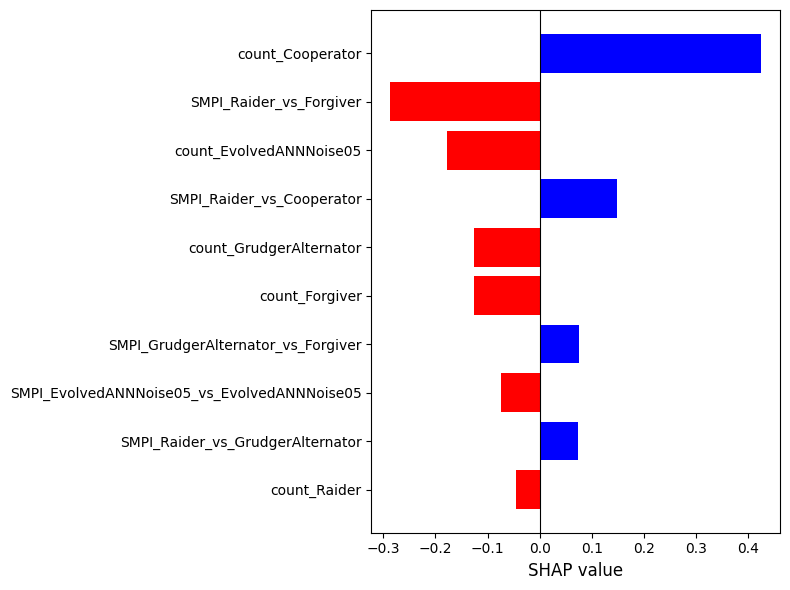

In [30]:
top_idx = np.abs(imp_vals).argsort()[::-1][:top_k]

top_features = [imp_names[i] for i in top_idx]
top_shapvals = imp_vals[top_idx]

colors = ['blue' if val >= 0 else 'red' for val in top_shapvals]

plt.figure(figsize=(8, 6))
bars = plt.barh(range(top_k), top_shapvals, color=colors)

plt.yticks(range(top_k), top_features, fontsize=10)
plt.gca().invert_yaxis() 
plt.axvline(0, color="black", linewidth=0.8)

plt.xlabel("SHAP value", fontsize=12)

plt.tight_layout()
plt.show()

In [31]:

N          = 500
n_labels   = y_train.shape[1]         
idx        = np.random.choice(len(X_train), N, replace=False)
X_sub      = X_train[idx]                 

all_shap = []
for x in X_sub:
    sv = explainer.shap_values(x.reshape(1, -1))
    sv = np.asarray(sv).reshape(n_labels, 21)
    all_shap.append(sv)

all_shap = np.stack(all_shap, axis=0)      

g_imp = np.abs(all_shap).mean(axis=(0, 1))     
rank  = g_imp.argsort()[::-1]   

print("=== GLOBAL TOP-15 FEATURES ===")
for r, i in enumerate(rank[:15], 1):
    print(f"{r:2d}. {feat_names[i]:<35}  mean|SHAP| = {g_imp[i]:.4f}")


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 227us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 199us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 237us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 198us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 242us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 225us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 231us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 261us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 222us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 217us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 198us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 196us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 5s 416us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 6s 476us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 217us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 216us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 220us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 224us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 216us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 219us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 240us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 222us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 220us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 228us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 229us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 220us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 219us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 196us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 217us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 216us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 223us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 216us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 220us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 217us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 222us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 220us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 223us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 237us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 198us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 199us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 216us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 236us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 198us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 194us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 197us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 227us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 221us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 196us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 197us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 179us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 183us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 188us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 187us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 188us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 187us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 189us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 188us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 188us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 191us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 190us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 194us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 188us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 198us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 2s 186us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 224us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 196us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 195us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 250us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 225us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 198us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 221us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 218us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 216us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 199us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 196us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 199us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 196us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 213us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 224us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 227us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 230us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 198us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 212us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 222us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 200us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 204us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 214us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 203us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 201us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 209us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 195us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 202us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 205us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 197us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 210us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 215us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 208us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 224us/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
13063/13063 ━━━━━━━━━━━━━━━━━━━━ 3s 206us/step


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]

=== GLOBAL TOP-15 FEATURES ===
 1. count_Cooperator                     mean|SHAP| = 0.0541
 2. SMPI_Raider_vs_Forgiver              mean|SHAP| = 0.0520
 3. count_EvolvedANNNoise05              mean|SHAP| = 0.0408
 4. count_Forgiver                       mean|SHAP| = 0.0293
 5. SMPI_Raider_vs_Cooperator            mean|SHAP| = 0.0274
 6. SMPI_Raider_vs_EvolvedANNNoise05     mean|SHAP| = 0.0251
 7. SMPI_EvolvedANNNoise05_vs_EvolvedANNNoise05  mean|SHAP| = 0.0197
 8. count_GrudgerAlternator              mean|SHAP| = 0.0192
 9. SMPI_Cooperator_vs_GrudgerAlternator  mean|SHAP| = 0.0192
10. SMPI_Raider_vs_GrudgerAlternator     mean|SHAP| = 0.0175
11. SMPI_Raider_vs_Raider                mean|SHAP| = 0.0150
12. count_Raider                         mean|SHAP| = 0.0143
13. SMPI_EvolvedANNNoise05_vs_Forgiver   mean|SHAP| = 0.0136
14. SMPI_GrudgerAlternator_vs_GrudgerAlternator  mean|SHAP| = 0.0132
15. SMPI_Cooperator_vs_Forgiver          mean|SHAP| = 0.0128


In [32]:
print(rank)

print("=== GLOBAL TOP-15 FEATURES ===")
for r, i in enumerate(rank[:15], 1):
    print(f"{r:2d}. {feat_names[i]:<35}  mean|SHAP|={g_imp[i]:.4f}")

[ 1  9  3  4  6  8 17  2 11  7  5  0 18 14 13 12 10 20 16 19 15]
=== GLOBAL TOP-15 FEATURES ===
 1. count_Cooperator                     mean|SHAP|=0.0541
 2. SMPI_Raider_vs_Forgiver              mean|SHAP|=0.0520
 3. count_EvolvedANNNoise05              mean|SHAP|=0.0408
 4. count_Forgiver                       mean|SHAP|=0.0293
 5. SMPI_Raider_vs_Cooperator            mean|SHAP|=0.0274
 6. SMPI_Raider_vs_EvolvedANNNoise05     mean|SHAP|=0.0251
 7. SMPI_EvolvedANNNoise05_vs_EvolvedANNNoise05  mean|SHAP|=0.0197
 8. count_GrudgerAlternator              mean|SHAP|=0.0192
 9. SMPI_Cooperator_vs_GrudgerAlternator  mean|SHAP|=0.0192
10. SMPI_Raider_vs_GrudgerAlternator     mean|SHAP|=0.0175
11. SMPI_Raider_vs_Raider                mean|SHAP|=0.0150
12. count_Raider                         mean|SHAP|=0.0143
13. SMPI_EvolvedANNNoise05_vs_Forgiver   mean|SHAP|=0.0136
14. SMPI_GrudgerAlternator_vs_GrudgerAlternator  mean|SHAP|=0.0132
15. SMPI_Cooperator_vs_Forgiver          mean|SHAP|=0.0128
